## init

In [1]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex,
    sneaky_matrix as sneaky
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline

import mars



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4
    print(f'Wrote {filename}')


|======== Timed report ========
| rs reduce       :     228.72ms  (228.718ms per; #1)
| rs reduce_vine  :   72378.42ms  ( 0.554ms per; #130687)
| flood_fill_visit:   73523.21ms  (73523.206ms per; #1)
|==============================
Wrote output/maybe_pipe_sparse-GB0.1-GS0.05-MA0-peps0.obj


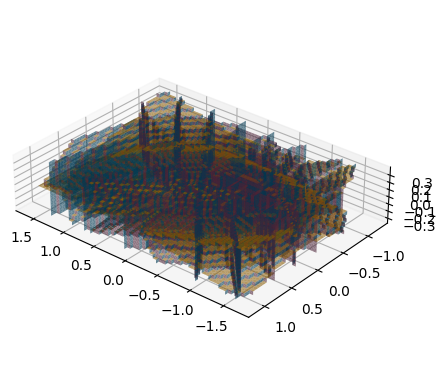

In [3]:
example = ex.maybepipe

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

rs_complex = mars.read_from_obj(example.filename)

rs_swaps = []
rs_states = {}
n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce'):
      rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
  else:
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce_vine'):
      rs_old_state = rs_states[old_cell]
      (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
      rs_swaps.append((old_cell, new_cell, swaps))
      rs_states[new_cell] = rs_new_state

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

rs_faces = []
rs_lines = []
for (old_cell, new_cell, swaps) in rs_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]

  swaps = swaps.pyclone()
  # swaps.prune_coboundary(rs_complex)
  swaps.prune_persistence(rs_complex, state_old, state_new, 0.01)
  if example.prune_dist is not None:
    swaps.prune_euclidian(rs_complex, example.prune_dist)

  swaps = list(filter(lambda t: t.dim == example.medial_axis, swaps.v))

  if 0 < len(swaps):
    rs_faces.append(gridd.dual_face(old_cell, new_cell))

export_obj(example, our_complex, rs_faces)
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, rs_faces, CameraOpt(azim=130, elev=30), skip_grid=True, skip_cube=True)

Wrote output/maybe_pipe_sparse-GB0.1-GS0.05-MA0-peps0.obj


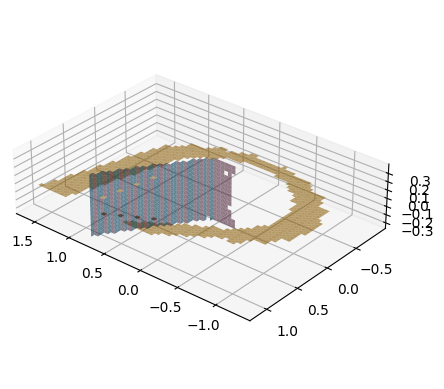

In [7]:
rs_faces = []
rs_lines = []
for (old_cell, new_cell, swaps) in rs_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]

  swaps = swaps.pyclone()
  # swaps.prune_coboundary(rs_complex)
  swaps.prune_persistence(rs_complex, state_old, state_new, 0.01)
  swaps.prune_euclidian(rs_complex, 0.5**2)
  if example.prune_dist is not None:
    swaps.prune_euclidian(rs_complex, example.prune_dist)

  swaps = list(filter(lambda t: t.dim == example.medial_axis, swaps.v))

  if 0 < len(swaps):
    rs_faces.append(gridd.dual_face(old_cell, new_cell))

export_obj(example, our_complex, rs_faces)
fig, ax = ourplot.plot_vineyard_results(our_complex, gridd, rs_faces, CameraOpt(azim=130, elev=30), skip_grid=True, skip_cube=True)